In [148]:
import bz2
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
from keras.layers import (
    Activation, Conv2D, Dense, Dropout, Flatten, MaxPooling2D)
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import np_utils
from pprint import pprint
from pylab import *
from sklearn.preprocessing import StandardScaler

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8

In [2]:
DATA = '../../data/cluster/year/'

In [3]:
[tensor for tensor in os.listdir(DATA) if tensor.endswith('.bz2')]

['tensor2000.pkl.bz2',
 'tensor2001.pkl.bz2',
 'tensor2002.pkl.bz2',
 'tensor2003.pkl.bz2',
 'tensor2004.pkl.bz2',
 'tensor2005.pkl.bz2',
 'tensor2006.pkl.bz2',
 'tensor2007.pkl.bz2',
 'tensor2008.pkl.bz2',
 'tensor2009.pkl.bz2',
 'tensor2010.pkl.bz2',
 'tensor2011.pkl.bz2',
 'tensor2012.pkl.bz2',
 'tensor2013.pkl.bz2',
 'tensor2014.pkl.bz2',
 'y_matrix2000.pkl.bz2',
 'y_matrix2001.pkl.bz2',
 'y_matrix2002.pkl.bz2',
 'y_matrix2003.pkl.bz2',
 'y_matrix2004.pkl.bz2',
 'y_matrix2005.pkl.bz2',
 'y_matrix2006.pkl.bz2',
 'y_matrix2007.pkl.bz2',
 'y_matrix2008.pkl.bz2',
 'y_matrix2009.pkl.bz2',
 'y_matrix2010.pkl.bz2',
 'y_matrix2011.pkl.bz2',
 'y_matrix2012.pkl.bz2',
 'y_matrix2013.pkl.bz2',
 'y_matrix2014.pkl.bz2']

In [4]:
def load_xy(data_path, year, verbose=False):
    x_path = data_path + 'tensor%d.pkl.bz2' % year
    y_path = data_path + 'y_matrix%d.pkl.bz2' % year
    if verbose: print('\nLoading X tensor from %s' % x_path)
    X = pickle.load(bz2.open(x_path, 'rb'))
    if verbose: print('Loading y tensor from %s' % y_path)
    Y = pickle.load(bz2.open(y_path, 'rb'))
    
    if verbose:
        print('  X: ', X.shape, '(width, height, layers)')
        print('  Y: ', Y.shape, '    (width, height)')
    return X, Y

In [5]:
X_2000, Y_2000 = load_xy(DATA, 2000, verbose=True)


Loading X tensor from ../../data/cluster/year/tensor2000.pkl.bz2
Loading y tensor from ../../data/cluster/year/y_matrix2000.pkl.bz2
  X:  (188, 353, 19) (width, height, layers)
  Y:  (188, 353)     (width, height)


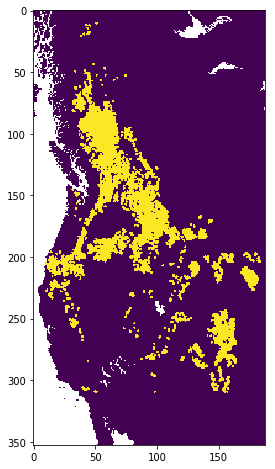

In [6]:
# Demonstrate accuracy
imshow(np.rot90(Y_2000));

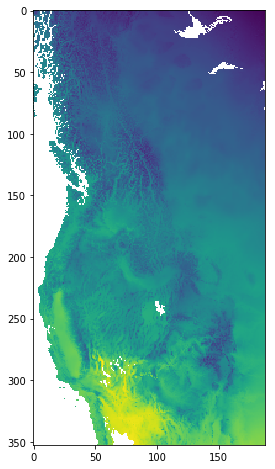

In [7]:
imshow(np.rot90(X_2000[:, :, 0]));

In [8]:
def load_xy_set(data_path, years, verbose=False):
    X_set = []
    Y_set = []
    
    for year in years:
        X, Y = load_xy(data_path, year, verbose)
        X_set.append(X)
        Y_set.append(Y)
    
    X = np.array(X_set)
    Y = np.array(Y_set)
    
    if verbose:
        print('\nX:', X.shape, '(years, width, height, layers)')
        print('Y:', Y.shape, '    (years, width, height)')

    return (X, Y)

In [9]:
test_years = range(2000, 2003)
valid_years = range(2003, 2006)
train_years = range(2006, 2015)

print('TRAINING DATA:')
X_train, Y_train = load_xy_set(DATA, train_years, verbose=True)

print('\n\n\nVALIDATION DATA:')
X_valid, Y_valid = load_xy_set(DATA, valid_years, verbose=True)

print('\n\n\nTEST DATA:')
X_test, Y_test  = load_xy_set(DATA, test_years, verbose=True)

TRAINING DATA:

Loading X tensor from ../../data/cluster/year/tensor2006.pkl.bz2
Loading y tensor from ../../data/cluster/year/y_matrix2006.pkl.bz2
  X:  (188, 353, 19) (width, height, layers)
  Y:  (188, 353)     (width, height)

Loading X tensor from ../../data/cluster/year/tensor2007.pkl.bz2
Loading y tensor from ../../data/cluster/year/y_matrix2007.pkl.bz2
  X:  (188, 353, 19) (width, height, layers)
  Y:  (188, 353)     (width, height)

Loading X tensor from ../../data/cluster/year/tensor2008.pkl.bz2
Loading y tensor from ../../data/cluster/year/y_matrix2008.pkl.bz2
  X:  (188, 353, 19) (width, height, layers)
  Y:  (188, 353)     (width, height)

Loading X tensor from ../../data/cluster/year/tensor2009.pkl.bz2
Loading y tensor from ../../data/cluster/year/y_matrix2009.pkl.bz2
  X:  (188, 353, 19) (width, height, layers)
  Y:  (188, 353)     (width, height)

Loading X tensor from ../../data/cluster/year/tensor2010.pkl.bz2
Loading y tensor from ../../data/cluster/year/y_matrix2010.

Summary:
```
Training:   X: (9, 188, 353, 19) (years, width, height, layers) (2006 - 2014, 80%)
Validation: X: (3, 188, 353, 19) (years, width, height, layers) (2003 - 2005, 20%)
Test:       X: (3, 188, 353, 19) (years, width, height, layers) (2000 - 2002, 20%) 
```

The goal now is, for each cell y, w, h (`year`, `width_location`, `height_location`) in the grid, create a _single_ X input that is a submatrix of shape `(1, 2*buffer + 1, 2*buffer + 1, layers)`, namely:<br/>
`X[year, w - buffer:w + buffer, h - buffer:h + buffer, :]`.<br/>
To simplify edge cases, we will simply discard those locations within `buffer` cells from any edge.<br/>
The output X will be of shape:<br/>
`(m, 2*buffer + 1, 2*buffer + 1, 19)`, where `m` is the number of training examples: <br/>
`m = years * (width - 2*buffer) * (height - 2*buffer)`.


However, because the data sets are too large to hold in memory, create instead, a function to create a random mini-batch instead, where `m` is the `batch_size`.

In [10]:
def normalize(X_train, X_valid, X_test):
    n_layers = X_train.shape[3]
    
    for layer in range(n_layers):
        layer_max = np.nanmax(X_train[:, :, :, layer])
        X_train[:, :, :, layer] /= layer_max
        X_valid[:, :, :, layer] /= layer_max
        X_test[:,  :, :, layer] /= layer_max
        
    return X_train, X_valid, X_test

In [11]:
train_norm, valid_norm, test_norm = normalize(X_train, X_valid, X_test)

[[        nan         nan         nan ...,  0.15624718  0.15657353
   0.11990228]
 [        nan         nan         nan ..., -0.00241547  0.0746588
   0.02962202]
 [        nan         nan         nan ..., -0.08595954 -0.10301935
   0.03329163]
 ..., 
 [ 0.73589765  0.73040974  0.73078878 ..., -0.24371968 -0.24037349
  -0.24453103]
 [ 0.73710083  0.73299883  0.73052768 ..., -0.2409969  -0.25298852
  -0.25258143]
 [ 0.73801894  0.73295737  0.73148481 ..., -0.25629902 -0.25978451
  -0.24793399]]


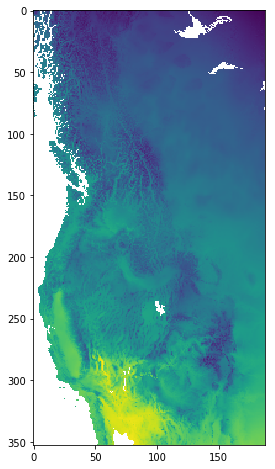

In [12]:
print(train_norm[0, :, :, 0])
imshow(np.rot90(train_norm[0, :, :, 0]));

In [77]:
train = (train_norm, Y_train)
valid = (valid_norm, Y_valid)
test  = (test_norm,  Y_test)

In [108]:
def data_generator(data, buffer_size):
    X_data, Y_data = data
    years, width, height, layers = X_data.shape
    
    def get_candidate():
        yr = np.random.choice(range(years))
        w = np.random.choice(range(buffer_size, width - buffer_size))
        h = np.random.choice(range(buffer_size, height - buffer_size))
        candidate = X_data[yr, 
                           w - buffer_size:w + buffer_size + 1, 
                           h - buffer_size:h + buffer_size + 1, 
                           :]
        mY = Y_data[yr, w, h]
        return candidate, mY
        
    while True:
        mX, mY = get_candidate()
        while sum(np.isnan(mX) > 0):
            mX, mY = get_candidate()
            
        mY = np.array(np_utils.to_categorical(mY, N_CLASSES))\
            .reshape([1, 2])
        mX = np.array(mX).reshape(
            [1, 2*buffer_size + 1, 2*buffer_size + 1, layers])
        yield mX, mY

In [109]:
train_gen_test = data_generator(train, BUFFER)
(mx_train, my_train) = next(train_gen_test)
valid_gen_test = data_generator(valid, BUFFER)
(mx_valid, my_valid) = next(valid_gen_test)
print(mx_train.shape, my_train.shape)
print(mx_valid.shape, my_valid.shape)

(1, 33, 33, 19) (1, 2)
(1, 33, 33, 19) (1, 2)


[[ 1.  0.]]
[[ 0.  1.]]


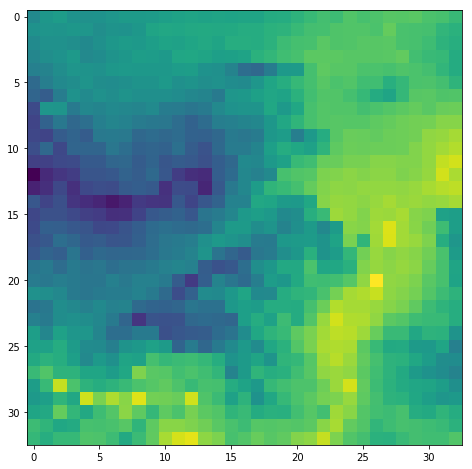

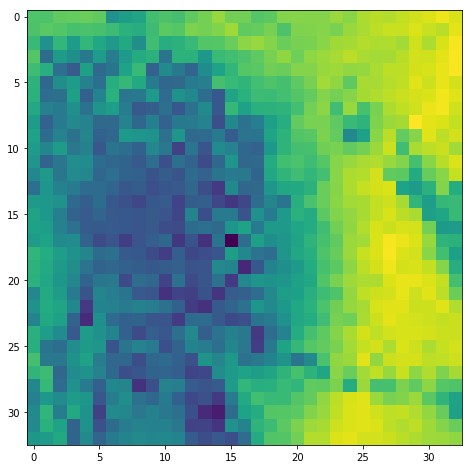

In [110]:
layer = np.random.choice(range(19))
print(my_train)
imshow(np.rot90(mx_train[0, :, :, layer]));

print(my_valid)
figure();
imshow(np.rot90(mx_valid[0, :, :, layer]));

In [362]:
best_val_loss = np.inf

# Begin Hyperparameter Tuning Here

In [398]:
BUFFER = 1 # Number of cells around each cell to include
N_CLASSES = 2
HEIGHT = WIDTH = 2*BUFFER + 1
CHANNELS = train_norm.shape[3]
ETA = 0.000001
BATCH_SIZE = 256
EPOCHS = 20000
DROPOUT = 0.65
BETA_1 = 0.9
BETA_2 = 0.999
EPSILON = 1e-08
DECAY = 0.0001
print('Input dimensions: %d x %d x %d (H x W x C)' 
      % (HEIGHT, WIDTH, CHANNELS))

Input dimensions: 3 x 3 x 19 (H x W x C)


In [399]:
def get_params():
    return {'ETA': ETA,
            'DROPOUT': DROPOUT,
            'BETA_1': BETA_1,
            'BETA_2': BETA_2,
            'EPSILON': EPSILON,
            'DECAY': DECAY,
            'EPOCHS': EPOCHS,
            'BATCH_SIZE': BATCH_SIZE,
            'BUFFER': BUFFER}

get_params()

{'BATCH_SIZE': 256,
 'BETA_1': 0.9,
 'BETA_2': 0.999,
 'BUFFER': 1,
 'DECAY': 0.0001,
 'DROPOUT': 0.65,
 'EPOCHS': 20000,
 'EPSILON': 1e-08,
 'ETA': 1e-06}

In [400]:
model = Sequential()
model.add(Conv2D(32, (5, 5), 
                 padding='same', 
                 input_shape=(HEIGHT, WIDTH, CHANNELS)))
# Dim: 33x33x32
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# 16x16x32
model.add(Dropout(DROPOUT))

'''
model.add(Conv2D(64, (3, 3), padding='same'))
# 16x16x64
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# 8x8x64
model.add(Dropout(DROPOUT))


model.add(Conv2D(128, (2, 2), padding='same'))
# 8x8x128
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# 4x4x128
model.add(Dropout(DROPOUT))

model.add(Flatten())
# 2048

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(DROPOUT))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(DROPOUT))

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(DROPOUT))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(DROPOUT))

model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(DROPOUT))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(DROPOUT))
'''

model.add(Flatten())

#model.add(Dense(32))
#model.add(Activation('relu'))
#model.add(Dropout(DROPOUT))

model.add(Dense(N_CLASSES))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_135 (Conv2D)          (None, 3, 3, 32)          15232     
_________________________________________________________________
activation_354 (Activation)  (None, 3, 3, 32)          0         
_________________________________________________________________
max_pooling2d_135 (MaxPoolin (None, 1, 1, 32)          0         
_________________________________________________________________
dropout_304 (Dropout)        (None, 1, 1, 32)          0         
_________________________________________________________________
flatten_47 (Flatten)         (None, 32)                0         
_________________________________________________________________
dense_220 (Dense)            (None, 2)                 66        
_________________________________________________________________
activation_355 (Activation)  (None, 2)                 0         
Total para

In [401]:
training_generator = data_generator(train, BUFFER)
validation_generator = data_generator(valid, BUFFER)

In [402]:
opt = Adam(
    lr=ETA, beta_1=BETA_1, beta_2=BETA_2, epsilon=EPSILON, decay=DECAY)

In [403]:
model.compile(
    loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
history = model.fit_generator(generator = training_generator,
                              steps_per_epoch = BATCH_SIZE,
                              epochs = EPOCHS,
                              validation_data = validation_generator,
                              validation_steps = BATCH_SIZE,
                              verbose=0)

In [ ]:
plt.plot(history.history['loss'], 'k-', label='train');
plt.plot(history.history['val_loss'], 'r-', label='valid');
plt.xlabel('epochs');
plt.ylabel('Loss (binary crossentropy)')
plt.legend(loc='best');

In [ ]:
this_run = np.mean(history.history['val_loss'][-100:])
print('This run: %.5f' % this_run)
print('Val. Acc.:', np.mean(history.history['val_acc'][-100:]))

In [ ]:
plt.plot(history.history['acc'], 'k-', label='train');
plt.plot(history.history['val_acc'], 'r-', label='valid');
plt.xlabel('epochs');
plt.ylabel('Accuracy')
plt.legend(loc='best');

In [ ]:
if this_run < best_val_loss:
    print('New Best Model Found!\n')
    best_val_loss = this_run
    train_loss_of_best = np.mean(history.history['loss'][-50:])
    best_params = get_params()
print('Best validation loss so far: %.5f' % best_val_loss)
print('Training loss of same model: %.5f' % train_loss_of_best)
print('Best hyperparameters found so far:')
pprint(best_params)